## Imports

In [37]:
import pandas as pd
import riskfolio as rf
import yfinance as yf
import matplotlib.pyplot as plt

## 1. Defining Investment Universe

In [25]:
# Define tickers for ETFs
tickers = ['SPY', 'TLT', 'GLD', 'DBC', 'DBMF']  # Equities, Bonds, Gold, Commodities, Managed Futures

# Download historical price data
data = yf.download(tickers, start="2010-01-01", end="2024-12-25")['Close']

# Calculate daily returns
returns = data.pct_change().dropna()
returns

[*********************100%***********************]  5 of 5 completed


Ticker,DBC,DBMF,GLD,SPY,TLT
Date,,,,,
2019-05-09,-0.005083,0.000560,0.002398,-0.003026,0.004099
2019-05-10,0.001916,0.000160,0.001898,0.005024,-0.001361
2019-05-13,-0.005099,-0.007313,0.010212,-0.025130,0.007856
2019-05-14,0.013453,0.005717,-0.001712,0.009043,-0.002943
2019-05-15,0.008850,0.012489,-0.000572,0.005858,0.006142
...,...,...,...,...,...
2024-12-18,-0.009058,-0.008840,-0.019185,-0.029803,-0.012504
2024-12-19,0.000000,-0.002601,0.001421,-0.000307,-0.015141
2024-12-20,0.006399,0.000745,0.010434,0.012011,0.005694


## 2. Allocation

In [29]:
# Create Portfolio Object
port = rp.Portfolio(returns=returns)

# Set the estimation methods for expected returns and covariance
method_mu = "hist"
method_cov = "hist"

# Update the portfolio object to use these methods
port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Run the optimization with a minimum return using the classicial
# mean-variance optimization framework
w = port.rp_optimization(
    model="Classic",
    rm="MV",
    hist=True,
    rf=0.05,
    b=None
)

# Display Weights
print(w)


       weights
DBC   0.145451
DBMF  0.279907
GLD   0.171168
SPY   0.157977
TLT   0.245497


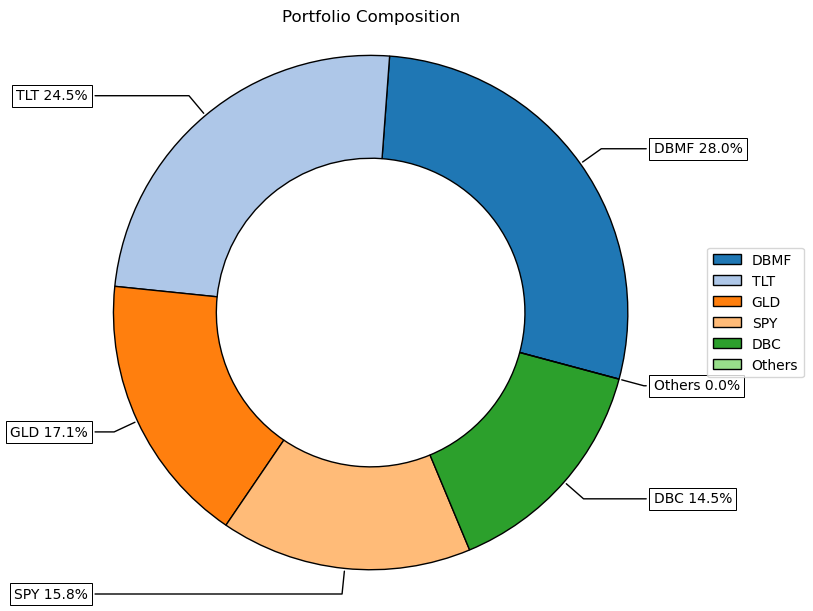

In [30]:
# Plot the portfolio weights determined by equal risk contribution
ax = rp.plot_pie(w=w)

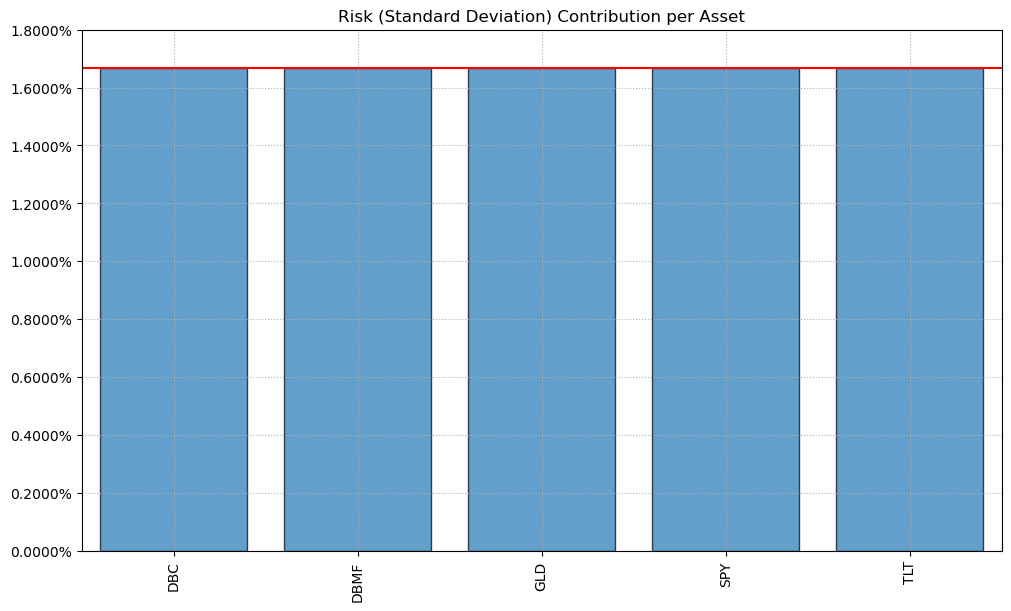

In [31]:
# Plot the risk contributions of each ETF which as we can see is
# equal.
ax = rp.plot_risk_con(
    w,
    cov=port.cov,
    returns=port.returns,
    rm="MV",
    rf=0.05
)

## 3. Backtesting

In [33]:
# Define backtesting parameters
lookback_period = 252  # Number of days to use for optimization (1 year)
rebalance_period = 21  # Rebalance every 21 trading days (1 month)


In [64]:
# Initialize variables
port_returns = []  # Portfolio returns
dates = []         # Dates of rebalancing
weights_history = []  # Store weights at each rebalancing period

# Perform rolling optimization and backtest
for i in range(lookback_period, len(returns), rebalance_period):
    # Use the lookback period for optimization
    train_returns = returns.iloc[i - lookback_period:i]
    
    # Create portfolio object and optimize
    port = rp.Portfolio(returns=train_returns)

    # Set the estimation methods for expected returns and covariance
    method_mu = "hist"
    method_cov = "hist"

    # Update the portfolio object to use these methods
    port.assets_stats(method_mu=method_mu, method_cov=method_cov)

    # Define constraints
    lower_bounds = pd.Series(0, index=returns.columns, dtype=float)  # Minimum allocation for all assets: 0%
    upper_bounds = pd.Series(1, index=returns.columns, dtype=float)  # Maximum allocation for all assets: 100%
    upper_bounds["DBMF"] = 0.2  # Specific constraint: DBMF max 20%
    lower_bounds["SPY"] = 0.3

    # Apply constraints
    port.lowerlng = lower_bounds
    port.upperlng = upper_bounds
    
    weights = port.rp_optimization(
                model="Classic",
                rm="MV",
                hist=True,
                rf=0.05,
                b=None
            )
    
    # Apply weights to the next rebalance period
    test_returns = returns.iloc[i:i + rebalance_period]
    portfolio_return = (test_returns @ weights).sum(axis=1)
    
    # Store results
    port_returns.extend(portfolio_return)
    dates.append(returns.index[i])
    weights_history.append(weights)

# Combine results into a DataFrame
portfolio_performance = pd.DataFrame({
    "Date": returns.index[lookback_period:lookback_period + len(port_returns)],
    "Portfolio_Returns": port_returns
}).set_index("Date")

# Calculate cumulative returns
portfolio_performance["Cumulative_Returns"] = (1 + portfolio_performance["Portfolio_Returns"]).cumprod()

# Display results
print(portfolio_performance.head())


            Portfolio_Returns  Cumulative_Returns
Date                                             
2020-05-08           0.001656            1.001656
2020-05-11          -0.005533            0.996113
2020-05-12          -0.000914            0.995203
2020-05-13           0.000451            0.995652
2020-05-14           0.009035            1.004648


In [68]:
weights_history

[       weights
 DBC   0.185473
 DBMF  0.224380
 GLD   0.199312
 SPY   0.137549
 TLT   0.253286,
        weights
 DBC   0.188268
 DBMF  0.226943
 GLD   0.195139
 SPY   0.138645
 TLT   0.251005,
        weights
 DBC   0.182694
 DBMF  0.230205
 GLD   0.197585
 SPY   0.135382
 TLT   0.254135,
        weights
 DBC   0.178220
 DBMF  0.232433
 GLD   0.196281
 SPY   0.136450
 TLT   0.256616,
        weights
 DBC   0.178974
 DBMF  0.238391
 GLD   0.183885
 SPY   0.135899
 TLT   0.262851,
        weights
 DBC   0.177406
 DBMF  0.243156
 GLD   0.177747
 SPY   0.129417
 TLT   0.272274,
        weights
 DBC   0.173191
 DBMF  0.247980
 GLD   0.178807
 SPY   0.126140
 TLT   0.273881,
        weights
 DBC   0.177883
 DBMF  0.243432
 GLD   0.171982
 SPY   0.127172
 TLT   0.279531,
        weights
 DBC   0.176066
 DBMF  0.237487
 GLD   0.170599
 SPY   0.129458
 TLT   0.286391,
        weights
 DBC   0.178268
 DBMF  0.229764
 GLD   0.170400
 SPY   0.130109
 TLT   0.291459,
        weights
 DBC   0.18468

In [65]:
portfolio_performance

,Portfolio_Returns,Cumulative_Returns
Date,,
2020-05-08,0.001656,1.001656
2020-05-11,-0.005533,0.996113
2020-05-12,-0.000914,0.995203
2020-05-13,0.000451,0.995652
2020-05-14,0.009035,1.004648
...,...,...
2024-12-18,-0.015036,1.296669
2024-12-19,-0.004223,1.291192
2024-12-20,0.006359,1.299403


In [66]:
# Extract SPY adjusted close prices
spy_prices = yf.download('SPY', start="2020-05-07", end="2024-12-25")['Close']

# Calculate SPY daily returns
spy_returns = spy_prices.pct_change().dropna()

# Calculate SPY cumulative returns
spy_cumulative_returns = (1 + spy_returns).cumprod()

aligned_spy_cumulative_returns = spy_cumulative_returns.loc[portfolio_performance.index]
aligned_spy_cumulative_returns

[*********************100%***********************]  1 of 1 completed


Ticker,SPY
Date,
2020-05-08,1.016546
2020-05-11,1.016755
2020-05-12,0.996489
2020-05-13,0.978866
2020-05-14,0.990580
...,...
2024-12-18,2.177970
2024-12-19,2.177301
2024-12-20,2.203453


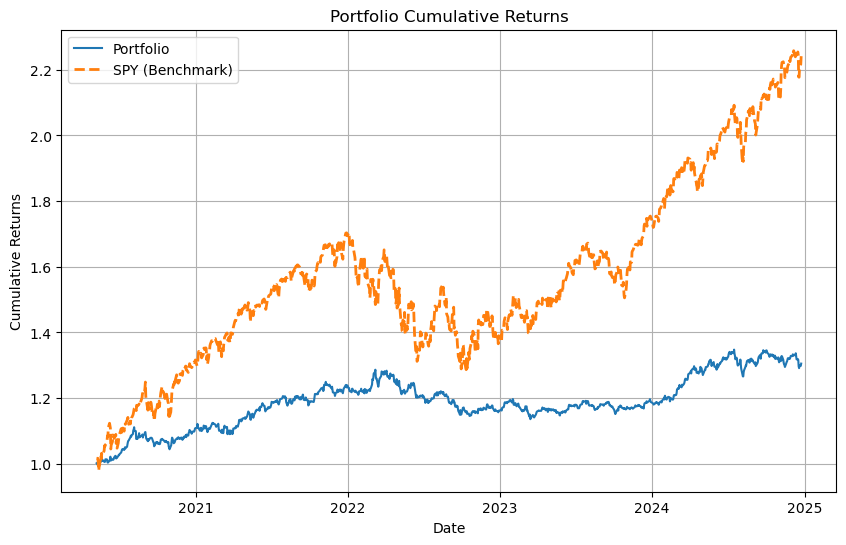

In [67]:
# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(portfolio_performance["Cumulative_Returns"], label="Portfolio")
plt.plot(aligned_spy_cumulative_returns, label="SPY (Benchmark)", linewidth=2, linestyle="--")
plt.title("Portfolio Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid()
plt.show()


## 4. Paper Trading

## 5. Live Implementation